In [5]:
%run -i 'scraping.py'

In [6]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [7]:
assert len(dataframe_list) == 3

In [8]:
dji = dataframe_list[0]
sp_500 = dataframe_list[1]
nasdaq = dataframe_list[2]

In [9]:
assert len(dji) == len(sp_500)
assert len(dji) == len(nasdaq)
assert len(sp_500) == len(nasdaq)

In [10]:
dji.set_index('Date', inplace = True)
sp_500.set_index('Date', inplace=True)
nasdaq.set_index('Date', inplace=True)

dji = dji.sort_index()
sp_500 = sp_500.sort_index()
nasdaq = nasdaq.sort_index()

In [11]:
dji.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-22,17918.35,17919.35,17807.41,17851.04,17851.04,112370000.0
2015-07-23,17853.78,17860.95,17705.03,17731.92,17731.92,88600000.0
2015-07-24,17731.05,17756.54,17553.73,17568.53,17568.53,103470000.0
2015-07-27,17561.78,17561.78,17399.17,17440.59,17440.59,117860000.0
2015-07-28,17449.81,17650.07,17449.81,17630.27,17630.27,103450000.0


In [12]:
sp_500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-22,2118.21,2118.51,2110.00,2114.15,2114.15,3.694070e+09
2015-07-23,2114.16,2116.87,2098.63,2102.15,2102.15,3.772810e+09
2015-07-24,2102.24,2106.01,2077.09,2079.65,2079.65,3.870040e+09
2015-07-27,2078.19,2078.19,2063.52,2067.64,2067.64,3.836750e+09
2015-07-28,2070.75,2095.60,2069.09,2093.25,2093.25,4.117740e+09


In [13]:
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-22,5146.03,5184.74,5145.78,5171.77,5171.77,2.035730e+09
2015-07-23,5180.33,5197.00,5137.64,5146.41,5146.41,2.003310e+09
2015-07-24,5166.91,5167.54,5084.51,5088.63,5088.63,2.004380e+09
2015-07-27,5055.92,5072.88,5032.69,5039.78,5039.78,1.942520e+09
2015-07-28,5063.44,5097.69,5025.61,5089.21,5089.21,2.025110e+09


In [14]:
# constants
TRAIN_SPLIT = len(dji) - 10 # same for all data
START_INDEX = 20

In [15]:
#standard scaler
standard_scaler = StandardScaler()
dji_standarized = standard_scaler.fit_transform(dji.values)
sp500_standarized = standard_scaler.fit_transform(sp_500.values)
nasdaq_standarized = standard_scaler.fit_transform(nasdaq.values)

In [16]:
assert dji_standarized.shape == (len(dji), 6)
assert sp500_standarized.shape == (len(sp_500), 6)
assert nasdaq_standarized.shape == (len(nasdaq), 6)

In [17]:
def train_data(dataset, target_index, start_index, train_split):
    """
    """
    data = []
    labels = []
    target = dataset[:, target_index]

    # model will be given 20 prices
    start_index = start_index
    end_index = train_split
    
    for i in range(start_index, end_index):
        indices = range(i - start_index, i)
        data.append(dataset[indices])
        labels.append(target[i])
    
    return np.array(data), np.array(labels)

In [18]:
dji_train, dji_label = train_data(dji_standarized, 4, START_INDEX, TRAIN_SPLIT)
sp500_train, sp500_label = train_data(sp500_standarized, 4, START_INDEX, TRAIN_SPLIT)
nasdaq_train, nasdaq_label = train_data(nasdaq_standarized, 4, START_INDEX, TRAIN_SPLIT)

In [19]:
# check shape of training data
assert dji_train.shape == (TRAIN_SPLIT - START_INDEX, 20, 6)
assert sp500_train.shape == (TRAIN_SPLIT - START_INDEX, 20, 6)
assert nasdaq_train.shape == (TRAIN_SPLIT - START_INDEX, 20, 6)

# check shape of label data
assert dji_label.shape == (TRAIN_SPLIT - START_INDEX,)
assert sp500_label.shape == (TRAIN_SPLIT - START_INDEX,)
assert nasdaq_label.shape == (TRAIN_SPLIT - START_INDEX,)

In [20]:
def validation_data(dataset, target_index, start_index):
    """
    """
    valid_data = []
    valid_labels = []
    target = dataset[:, target_index]

    # set index 
    start_index = start_index
    end_index = len(dataset)

    for i in range(start_index, end_index):
        indices = range(i - 20, i)
        valid_data.append(dataset[indices])
        valid_labels.append(target[i])

    return np.array(valid_data), np.array(valid_labels)

In [21]:
dji_valid_data, dji_valid_label = validation_data(dji_standarized, 4, TRAIN_SPLIT)
sp500_valid_data, sp500_valid_label = validation_data(sp500_standarized, 4, TRAIN_SPLIT)
nasdaq_valid_data, nasdaq_valid_label = validation_data(nasdaq_standarized, 4, TRAIN_SPLIT)

In [22]:
# check shape of validation data
assert dji_valid_data.shape == (10, 20, 6)
assert sp500_valid_data.shape == (10, 20, 6)
assert nasdaq_valid_data.shape == (10, 20, 6)

# check shape of validation label
assert dji_valid_label.shape == (10,)
assert sp500_valid_label.shape == (10,)
assert nasdaq_valid_label.shape == (10,)

In [54]:
# DIJ time series
dji_model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = dji_train.shape[-2:]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/dji_model.h5", save_best_only=True)
dji_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

history = dji_model.fit(dji_train, dji_label, epochs=100,
                    validation_data=(dji_valid_data, dji_valid_label),
                        callbacks=[callback, checkpoint_cb])

dji_predict = dji_model.predict(dji_valid_data)

Epoch 1/100
39/39 [==============================] - 2s 39ms/step - loss: 0.2049 - val_loss: 0.1110
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1409 - val_loss: 0.3056
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1308 - val_loss: 0.3106
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.2081
Epoch 5/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1108 - val_loss: 0.2045
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1084 - val_loss: 0.0847
Epoch 7/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1071 - val_loss: 0.2266
Epoch 8/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0969 - val_loss: 0.0794
Epoch 9/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0958 - val_loss: 0.2165
Epoch 10/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0943 - val_loss: 0.0971

In [55]:
import os

def save_model(model_version, model_name, model):
    """
    Save model to upload to Google Cloud Platform
    """
    model_path = os.path.join(model_name, model_version)
    tf.saved_model.save(model, model_path)

In [56]:
save_model('0001', 'dji_model', dji_model)

INFO:tensorflow:Assets written to: dji_model/0001/assets


In [57]:
def unstandarize(predict, target_data):
    """
    Unstandarize the data to plot for graph
    """
    mean = target_data.mean()
    std = target_data.std()
    unstandarized_arr = predict*std + mean
    return unstandarized_arr

In [58]:
dji_unstan_predict = unstandarize(dji_predict, dji['Adj Close'].values)

In [59]:
def plot_valid_predict(data, train_split, predict, span):
    """
    Plot history, true future, and predicted future
    """
    train_split = len(data) - train_split
    adj_close = [x for x in data['Adj Close'].values]
    train_date = data.index[:train_split]
            
    plt.figure(figsize=(18, 8))
    plt.plot(data.index[-20:-10], adj_close[-20:-10], label='History')
    plt.plot(data.index[-train_split:], adj_close[-train_split:], label='True Future')
    plt.plot(data.index[-train_split:], predict, label='Predicted Price')
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.show()

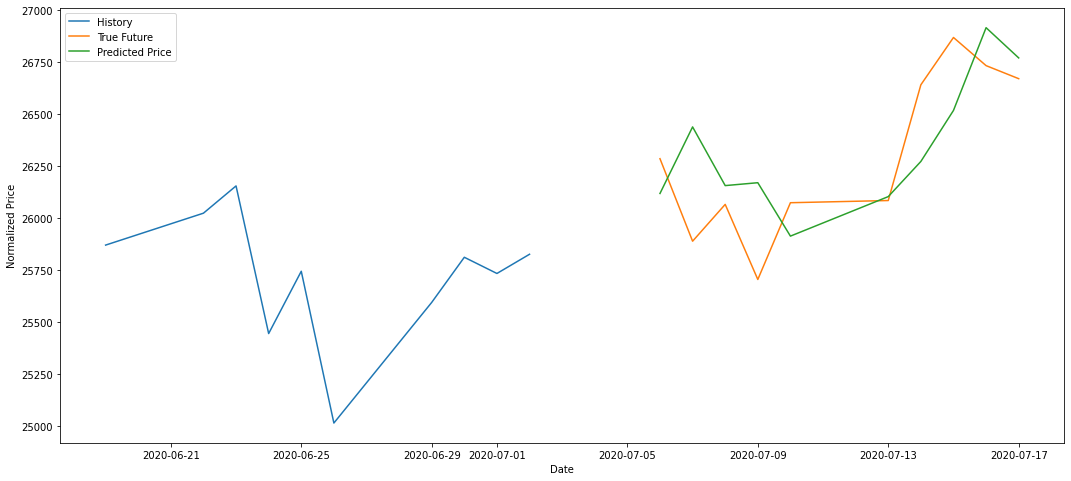

In [60]:
plot_valid_predict(dji, TRAIN_SPLIT, dji_unstan_predict, 20)

In [61]:
# S&P 500 model
sp500_model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = nasdaq_train.shape[-2:]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/sp500_model.h5", save_best_only=True)
sp500_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

history = sp500_model.fit(sp500_train, sp500_label, epochs=100,
                    validation_data=(sp500_valid_data, sp500_valid_label),
                        callbacks=[callback, checkpoint_cb])

sp500_predict = sp500_model.predict(sp500_valid_data)

Epoch 1/100
39/39 [==============================] - 2s 39ms/step - loss: 0.1929 - val_loss: 0.0641
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1461 - val_loss: 0.3885
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1306 - val_loss: 0.2166
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1254 - val_loss: 0.0997
Epoch 5/100
39/39 [==============================] - 1s 22ms/step - loss: 0.1142 - val_loss: 0.0503
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1119 - val_loss: 0.2686
Epoch 7/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1091 - val_loss: 0.1075
Epoch 8/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1041 - val_loss: 0.7012
Epoch 9/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1039 - val_loss: 0.0830
Epoch 10/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0974 - val_loss: 0.1864

In [62]:
save_model('0001', 'sp500_model', sp500_model)

INFO:tensorflow:Assets written to: sp500_model/0001/assets


In [63]:
sp500_unstan_predict = unstandarize(sp500_predict, sp_500['Adj Close'].values)

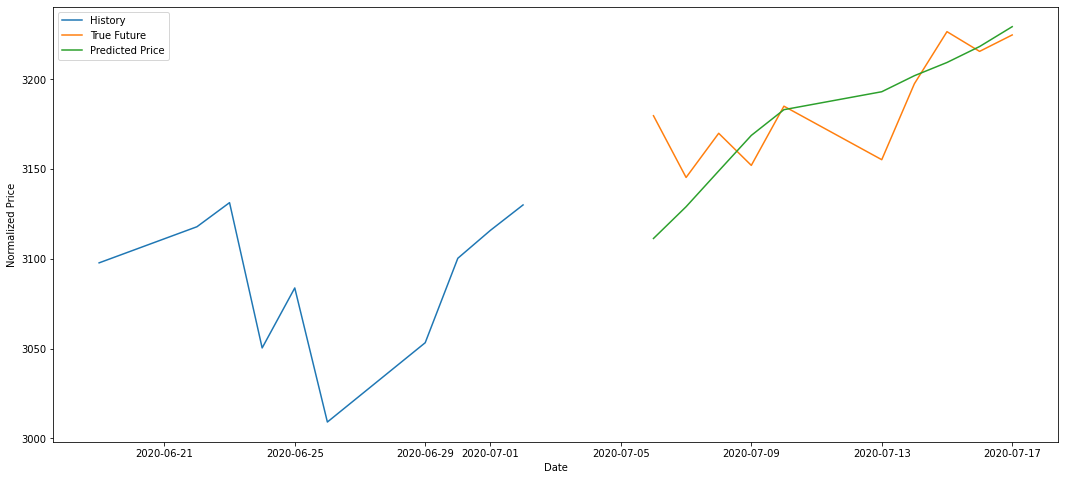

In [64]:
plot_valid_predict(sp_500, TRAIN_SPLIT, sp500_unstan_predict, 20)

In [65]:
# NASDAQ model
nasdaq_model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = nasdaq_train.shape[-2:]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/nasdaq_model.h5", save_best_only=True)
nasdaq_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

history = nasdaq_model.fit(nasdaq_train, nasdaq_label, epochs=100,
                    validation_data=(nasdaq_valid_data, nasdaq_valid_label),
                        callbacks=[callback, checkpoint_cb])

nasdaq_predict = nasdaq_model.predict(nasdaq_valid_data)

Epoch 1/100
39/39 [==============================] - 2s 39ms/step - loss: 0.1971 - val_loss: 0.5891
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1252 - val_loss: 0.7309
Epoch 3/100
39/39 [==============================] - 1s 22ms/step - loss: 0.1174 - val_loss: 0.0451
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1112 - val_loss: 0.0496
Epoch 5/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1012 - val_loss: 0.3730
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1044 - val_loss: 0.0696
Epoch 7/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0997 - val_loss: 0.5105
Epoch 8/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0957 - val_loss: 0.3430
Epoch 9/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0887 - val_loss: 0.3513
Epoch 10/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0876 - val_loss: 0.1251

In [66]:
save_model('0001', 'nasdaq_model', nasdaq_model)

INFO:tensorflow:Assets written to: nasdaq_model/0001/assets


In [67]:
nasdaq_unstan_predict = unstandarize(nasdaq_predict, nasdaq['Adj Close'].values)

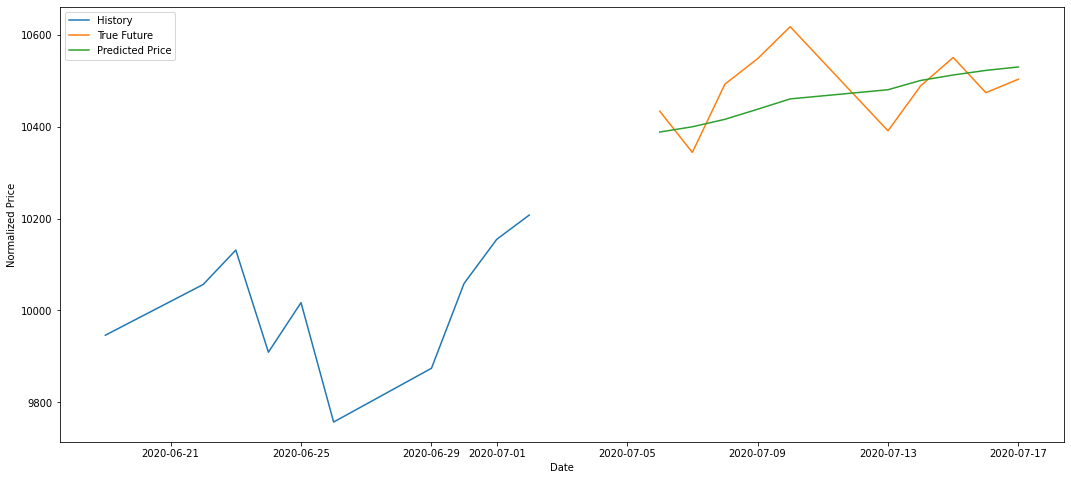

In [68]:
plot_valid_predict(nasdaq, TRAIN_SPLIT, nasdaq_unstan_predict, 20)